# Experiment on CNN

In [72]:
import kagglehub

path = kagglehub.dataset_download("agrigorev/clothing-dataset-full")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Utilisateur\.cache\kagglehub\datasets\agrigorev\clothing-dataset-full\versions\1


## Filter out corrupted images

In [73]:
import os

num_skipped = 0
valid_image = []  # Store names of deleted files

for folder_name in ("images_compressed", "images_original"):
    folder_path = os.path.join(path, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
        else:
            valid_image.append(fname.lstrip("0").removesuffix(".jpg"))

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


## Load the images, remove the corrupted one

In [74]:
import torch
import torchvision.ops as ops
import numpy as np
import pandas as pd
from PIL import Image  # ✅ Missing import

def resize_with_roi_align(image_np, output_size=(400, 400)):
    H, W, C = image_np.shape
    image_tensor = torch.from_numpy(image_np).permute(2, 0, 1).unsqueeze(0).float()  # (1, 3, H, W)

    crop_h, crop_w = output_size
    y1 = max(0, (H - crop_h) // 2)
    x1 = max(0, (W - crop_w) // 2)
    y2 = min(H, y1 + crop_h)
    x2 = min(W, x1 + crop_w)

    rois = torch.tensor([[0, x1, y1, x2, y2]], dtype=torch.float32)
    cropped = ops.roi_align(image_tensor, rois, output_size=output_size, spatial_scale=1.0)

    return cropped.squeeze(0).permute(1, 2, 0).numpy()

def load_image(image_id):
    image_path = f"{path}/images_compressed/{image_id}.jpg"
    return np.array(Image.open(image_path))

df = pd.read_csv(path + "/images.csv", na_values=["Not sure"])
df = df.dropna()
df = df[df['image'].isin(valid_image)].reset_index(drop=True)
df['image_data'] = df['image'].apply(load_image)
df['resized_image'] = df['image_data'].apply(resize_with_roi_align)



In [75]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

df

,image,sender_id,label,kids,image_data,resized_image,label_encoded
0,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False,"[[[170, 133, 104], [169, 132, 103], [169, 132,...","[[[180.0, 147.0, 116.0], [181.0, 148.0, 117.0]...",16
1,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False,"[[[182, 151, 120], [183, 152, 121], [172, 141,...","[[[117.5, 83.5, 71.5], [118.5, 84.5, 72.5], [1...",16
2,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False,"[[[206, 150, 89], [206, 150, 89], [207, 151, 9...","[[[211.25, 163.75, 94.0], [211.75, 162.75, 93....",12
3,5d3a1404-697f-479f-9090-c1ecd0413d27,138,Shorts,False,"[[[210, 180, 146], [210, 180, 146], [209, 179,...","[[[152.0, 113.0, 84.0], [150.75, 111.75, 82.75...",13
4,b0c03127-9dfb-4573-8934-1958396937bf,138,Shirt,False,"[[[211, 192, 159], [214, 195, 162], [215, 195,...","[[[180.5, 136.25, 105.5], [162.0, 119.0, 89.5]...",11
...,...,...,...,...,...,...,...
4841,dfd4079d-967b-4b3e-8574-fbac11b58103,204,Shorts,False,"[[[189, 188, 184], [190, 189, 185], [191, 190,...","[[[191.75, 190.75, 186.75], [192.25, 191.25, 1...",13
4842,befa14be-8140-4faf-8061-1039947e329d,204,Body,True,"[[[88, 55, 38], [89, 56, 39], [89, 56, 39], [8...","[[[96.5, 64.5, 43.5], [101.5, 69.5, 48.5], [10...",2
4843,5379356a-40ee-4890-b416-2336a7d84061,310,Shorts,False,"[[[156, 156, 158], [162, 162, 164], [164, 164,...","[[[169.25, 169.25, 171.25], [162.25, 162.25, 1...",13
4844,65507fb8-3456-4c15-b53e-d1b03bf71a59,204,Shoes,False,"[[[180, 179, 175], [180, 179, 175], [181, 180,...","[[[186.5, 185.5, 181.5], [187.75, 186.75, 182....",12


In [76]:

for i, name in enumerate(df["label"].unique()):
    print(i, name, (df["label"] == name).count())


0 T-Shirt 4846
1 Shoes 4846
2 Shorts 4846
3 Shirt 4846
4 Pants 4846
5 Skirt 4846
6 Other 4846
7 Outwear 4846
8 Top 4846
9 Dress 4846
10 Body 4846
11 Longsleeve 4846
12 Undershirt 4846
13 Hat 4846
14 Polo 4846
15 Blouse 4846
16 Hoodie 4846
17 Skip 4846
18 Blazer 4846


In [77]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

def print_accuracy(y_test, y_pred):
    print("Absolute error:", (y_test != y_pred).sum())
    print("Accuracy:", accuracy_score(y_test, y_pred))

    print("F1-scores (macro):", f1_score(y_test, y_pred, average='macro'))
    print("F1-scores (weighted):", f1_score(y_test, y_pred, average='weighted'))

    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.tight_layout()  # Ensure everything fits well
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SeparableConv2d(nn.Module):
    """
    Depthwise separable convolution layer.
    This will mimic the SeparableConv2D in Keras.
    """
    def __init__(self, in_channels, out_channels, kernel_size, padding=1, stride=1):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride=stride, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class CustomModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CustomModel, self).__init__()

        # Input normalization (Rescaling)
        self.rescale = nn.Sequential(
            nn.BatchNorm2d(input_shape[0])  # Assuming the input is in CHW format, scale by 1/255
        )
        
        # Entry block
        self.conv1 = nn.Conv2d(input_shape[0], 128, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU()

        # Residual Block 1, 2, 3
        self.res_block1 = self._residual_block(128, 256)
        self.res_block2 = self._residual_block(256, 512)
        self.res_block3 = self._residual_block(512, 728)

        # Final separable conv block
        self.conv_last = SeparableConv2d(728, 1024, 3)
        self.bn_last = nn.BatchNorm2d(1024)
        
        # Global average pooling and dropout
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.25)
        
        # Fully connected output layer
        self.fc = nn.Linear(1024, num_classes)

    def _residual_block(self, in_channels, out_channels):
        """
        Creates a residual block with separable convolutions.
        """
        block = nn.Sequential(
            SeparableConv2d(in_channels, out_channels, 3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            SeparableConv2d(out_channels, out_channels, 3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1)  # Max pooling layer
        )
        return block

    def forward(self, x):
        # Input Rescaling
        x = self.rescale(x)

        # Entry block
        x = self.relu(self.bn1(self.conv1(x)))

        # Residual blocks
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)

        # Final separable convolution
        x = self.relu(self.bn_last(self.conv_last(x)))

        # Global average pooling
        x = self.global_pool(x)
        x = torch.flatten(x, 1)  # Flatten the output for the fully connected layer

        # Dropout
        x = self.dropout(x)

        # Fully connected layer
        x = self.fc(x)
        return x


In [ ]:
import torch.nn as nn


class MyTestModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        self.rescale = nn.Sequential(
            nn.BatchNorm2d(input_shape[0])
        )
        self.conv1 = nn.Conv2d(input_shape[0], )

    def forward(self, x):
        pass

In [79]:
import torch.optim as optim
from tqdm import tqdm

def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        avg_loss = train_loss / total
        accuracy = 100.0 * correct / total
        print(f"Train Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")

        # Optional: validate
        if val_loader is not None:
            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item() * images.size(0)
                    _, predicted = outputs.max(1)
                    correct += predicted.eq(labels).sum().item()
                    total += labels.size(0)

            avg_val_loss = val_loss / total
            val_accuracy = 100.0 * correct / total
            print(f"Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")
    return model


## Create train test split

In [80]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset

class AugmentedImageDataset(Dataset):
    def __init__(self, images, labels, augment=True):
        self.images = images
        self.labels = labels
        self.augment = augment
        self.transform = transforms.Compose([
            # transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            # transforms.RandomResizedCrop(400, scale=(0.8, 1.0)),
            # transforms.ColorJitter(brightness=0.2, contrast=0.2),
            # transforms.ToTensor(),  # (C, H, W) in [0,1]
        ])
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.augment:
            image = self.transform(image)
        # else:
        #     image = transforms.ToTensor()(image)
        
        return image, label


In [81]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from PIL import Image

X = df["resized_image"]
y = df["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8
)
print(X_train.values[0].shape)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(np.stack(X_train.values), dtype=torch.float32)  # Assuming X is NumPy array
X_test_tensor = torch.tensor(np.stack(X_test.values), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # CrossEntropy requires long tensor for labels
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

print(X_train_tensor[0].shape)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# train_dataset = AugmentedImageDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader objects
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


(400, 400, 3)
torch.Size([400, 400, 3])


In [82]:
print(f"Number of samples: {len(train_dataset)}")

# Get one image and label
image, label = train_dataset[0]
print(f"Image shape: {image.shape}")  # Should be (3, 400, 400)
print(f"Label: {label}")


# import matplotlib.pyplot as plt

# # image, label = train_dataset[i]
# # print(image.shape)
# # print(label)

# # Show 6 augmented images from the training dataset

# for i in range(3):
#     image, label = train_dataset[i]  # This will apply augmentation if enabled
#     name_label = label_encoder.inverse_transform([label.item()])[0]
#     image_np = image.numpy().astype(np.uint8)  # Convert from (C, H, W) to (H, W, C)
#     plt.imshow(image_np)
#     plt.title(f"Label: {label}, {name_label}")
#     plt.axis("off")
#     plt.show()


Number of samples: 3876
Image shape: torch.Size([400, 400, 3])
Label: 16


In [83]:
# Define input shape and number of classes
input_shape = (400, 400, 3)
num_classes = 19  # 20 but I removed "Not sure"

# Initialize the model
model = CustomModel(input_shape, num_classes)

# Test with a random input tensor
model = train_model(model, train_loader, val_loader=test_loader, num_epochs=10)

Epoch 1/10: 100%|██████████| 61/61 [00:04<00:00, 13.17it/s]


Train Loss: 2.2806 | Accuracy: 32.07%
Val Loss: 2.1745 | Val Accuracy: 35.36%


Epoch 2/10: 100%|██████████| 61/61 [00:03<00:00, 16.70it/s]


Train Loss: 1.9948 | Accuracy: 41.05%
Val Loss: 2.0527 | Val Accuracy: 40.93%


Epoch 3/10: 100%|██████████| 61/61 [00:03<00:00, 19.27it/s]


Train Loss: 1.8173 | Accuracy: 47.39%
Val Loss: 1.9036 | Val Accuracy: 44.64%


Epoch 4/10: 100%|██████████| 61/61 [00:03<00:00, 19.57it/s]


Train Loss: 1.6849 | Accuracy: 50.88%
Val Loss: 1.8900 | Val Accuracy: 43.61%


Epoch 5/10: 100%|██████████| 61/61 [00:03<00:00, 19.71it/s]


Train Loss: 1.5714 | Accuracy: 52.76%
Val Loss: 1.7773 | Val Accuracy: 47.63%


Epoch 6/10: 100%|██████████| 61/61 [00:03<00:00, 19.66it/s]


Train Loss: 1.4196 | Accuracy: 58.15%
Val Loss: 1.6989 | Val Accuracy: 50.31%


Epoch 7/10: 100%|██████████| 61/61 [00:03<00:00, 19.79it/s]


Train Loss: 1.3130 | Accuracy: 60.06%
Val Loss: 1.8400 | Val Accuracy: 47.42%


Epoch 8/10: 100%|██████████| 61/61 [00:03<00:00, 19.81it/s]


Train Loss: 1.1250 | Accuracy: 66.18%
Val Loss: 1.8307 | Val Accuracy: 48.76%


Epoch 9/10: 100%|██████████| 61/61 [00:03<00:00, 19.64it/s]


Train Loss: 1.0314 | Accuracy: 67.41%
Val Loss: 1.9950 | Val Accuracy: 48.97%


Epoch 10/10: 100%|██████████| 61/61 [00:03<00:00, 19.70it/s]


Train Loss: 0.8975 | Accuracy: 72.16%
Val Loss: 1.9399 | Val Accuracy: 49.69%


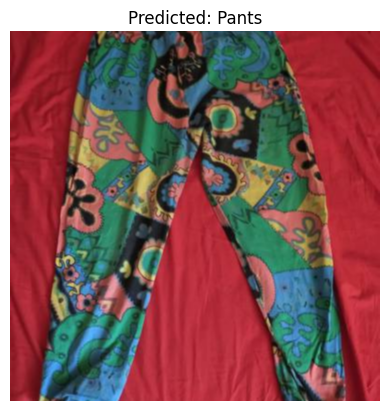

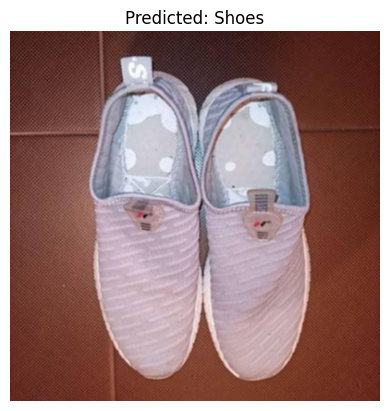

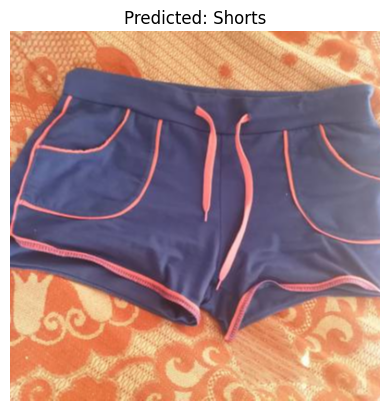

In [84]:
# Get the first image from X_test (make sure it's in the correct shape for the model)
import matplotlib.pyplot as plt 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def do_a_pred(i):
    image = X_test_tensor[i].unsqueeze(0).to(device)  # Add batch dimension (from (C, H, W) to (1, C, H, W))
    # Make a prediction
    model.eval()  # 
    with torch.no_grad():
        output = model(image)

    # Get the predicted class (index of the maximum logit/probability)
    _, predicted_class = torch.max(output, 1)

    # Convert the predicted class to the original label
    predicted_label = label_encoder.inverse_transform([predicted_class.item()])[0]

    # Get the actual image (remove batch dimension and convert to numpy array)
    image_to_show = X_test.values[i].astype(np.uint8)

    # Plot the image with the predicted label
    plt.imshow(image_to_show)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

do_a_pred(0)
do_a_pred(1)
do_a_pred(2)